# S2VSR 2023-06 cosine correction
The PyrNet for [Small Scale Variability of Solar Radiation (S2VSR)](https://www.arm.gov/research/campaigns/sgp2023s2vsr) was set up for calibration on the ARM-SGP guest instrument facility (**GIF**) for calibration from 2023-06-02 to 2023-06-08. Here, the PyrNet data is calibrated with the absolute calibration from the same period ([S2VSR absolute calibration](#sec-calibration-s2vsr)). As the PyrNet pyranometer are known for major directional sensibility, a correction function depending on solar zenith angle is fitted against the ARM-SGP reference measurements. 


## Imports

In [1]:
from IPython.display import display, Latex
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
import scipy

## Load data
The one minute ARM-SGP global horizontal downward irradiance (GHI) and PyrNet GHI for the reference period were loaded. The two datasets were then filtered so that only clearsky times remain. Clarsky times are by definition whole minutes in which more than 70% of all PyrNet stations, have a clearsky flag that is TRUE according to the clearsky detection algorithm by [Reno and Hansen (2016)](https://doi.org/10.1016/j.renene.2015.12.031). After that step the PyrNet GHI data was averaged over all stations. The ARM-SGP data remained unchanged. These two GHI datasets were then reordered according to the respective solar zenith angle for angles between 10 and 90 degree and averaged over 0.1 degree wide bins. Pyr_ghi then contains the GHI values from the pyranometer measurements and ARM_data the ARM-SGP GHI data with respect to the solar zenith angle bins.

In [2]:
ARM_data= xr.open_dataset('pyrnet_s2vsr_szen_bins_ARM.nc')
ARM_data

<xarray.Dataset>
Dimensions:  (szen: 801)
Coordinates:
  * szen     (szen) float32 10.0 10.1 10.2 10.3 10.4 ... 89.7 89.8 89.9 90.0
Data variables:
    ghi      (szen) float64 ...

In [3]:
Pyr_ghi= xr.open_dataset('pyrnet_s2vsr_szen_bins_pyranometer_avg.nc')
Pyr_ghi

<xarray.Dataset>
Dimensions:  (szen: 801)
Coordinates:
  * szen     (szen) float32 10.0 10.1 10.2 10.3 10.4 ... 89.7 89.8 89.9 90.0
Data variables:
    ghi      (szen) float64 ...

# Determine the cosine correction
Calculate the cosine correction for the Pyranometer measurements. A cubic relationship between the cosine of the solar zenith angle (mu) and the ratio of the ARM measurements to pyranometer measurements (correction-factor) is assumed. 

In [4]:
def cubic_function(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x + d

def objective_function(coefficients, x, y):
    a, b, c, d = coefficients
    y_pred = cubic_function(x, a, b, c, d)
    error = np.sum((y - y_pred) ** 2)
    return error
bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5)]

result = scipy.optimize.differential_evolution(
    objective_function,
    args=(np.cos(np.deg2rad(ARM_data.szen)), ARM_data.ghi/Pyr_ghi.ghi),
    bounds=bounds,
    seed=1
)
result

 message: Optimization terminated successfully.
 success: True
     fun: 0.35222329130203905
       x: [-2.227e+00  4.366e+00 -2.524e+00  1.385e+00]
     nit: 57
    nfev: 3485

In [5]:
print("Best cubic fit:")
a3, a2, a1, a0 = result.x
display(Latex(
    rf"""
    {a3:+.3f}$x^3${a2:+.3f}$x^2${a1:+.3f}$x${a0:+.3f}
    """
))

Best cubic fit:


<IPython.core.display.Latex object>

# Results 
Plotting the best fit and the correction-factor in respect to the solar zenith angle. For comparison also the cosine correction by [Barry et al. (2023)](https://doi.org/10.5194/amt-16-4975-2023) for the MetPVNet campaign is plotted. 

In [6]:
# Coefficients from Barry et al. 2023:
b3, b2, b1, b0 = [ -3.01, 5.59, -3.04, 1.45 ]
display(Latex(
    rf"""
    MetPVNet: {b3:+.3f}$x^3${b2:+.3f}$x^2${b1:+.3f}$x${b0:+.3f}
    
    S2VSR: {a3:+.3f}$x^3${a2:+.3f}$x^2${a1:+.3f}$x${a0:+.3f}
    """
))

<IPython.core.display.Latex object>

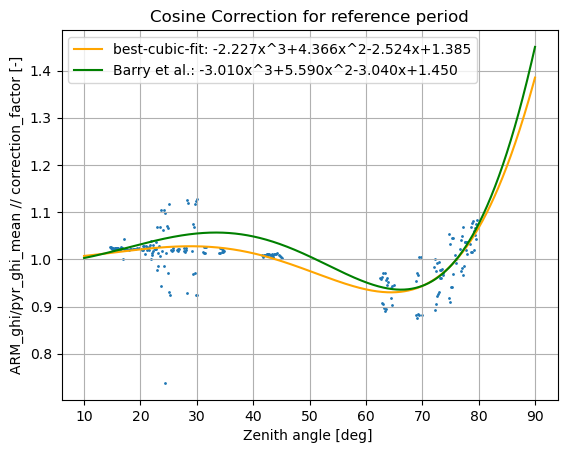

In [7]:
plt.scatter(ARM_data.szen, ARM_data.ghi/Pyr_ghi.ghi, s=1)
plt.title('Cosine Correction for reference period')
mu0 = np.cos(np.deg2rad(ARM_data.szen))
plt.plot(ARM_data.szen, a3*mu0**3 + a2*mu0**2 + a1*mu0 + a0,
         color='orange', label=f'best-cubic-fit: {a3:+.3f}x^3{a2:+.3f}x^2{a1:+.3f}x{a0:+.3f}')
plt.plot(ARM_data.szen, b3*mu0**3 + b2*mu0**2 + b1*mu0 + b0,
         color='green', label=f'Barry et al.: {b3:+.3f}x^3{b2:+.3f}x^2{b1:+.3f}x{b0:+.3f}')
plt.legend()
plt.xlabel('Zenith angle [deg] ')
plt.ylabel('ARM_ghi/pyr_ghi_mean // correction_factor [-]')
plt.grid(True)
plt.show()